In [1]:
import os
os.chdir("../../../../")

In [2]:
os.environ['CUDA_VISIBLE_DEVICES']=str(2)

In [3]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import pandas as pd
from functools import partial
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
from datasets.dataset_loader import dataset_load
from utilities import plot, gmm, errors, predict, preprocess
from models import seq2point_gaussian

In [4]:
train ={1:{
              'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                3: {
                    'start_time': "2011-04-19" ,
                    'end_time': "2011-05-22"
                },
                2: {
                    'start_time': "2011-04-21" ,
                    'end_time': "2011-05-21"
                },
                5: {
                    'start_time': "2011-04-22" ,
                    'end_time': "2011-06-01"
                }}
test = {6: {
                    'start_time': "2011-05-25" ,
                    'end_time': "2011-06-13"
                }}
appliances = ["Refrigerator"]

In [5]:
x_train, y_train,x_cal, y_cal, x_test, y_test, x_test_timestamp, scaler_x, scaler_y = dataset_load(appliances, train, test,n=99)

In [6]:
training_predictions_df = pd.DataFrame()
testing_predictions_df = pd.DataFrame()
# training_predictions_df["Timestamp"] = x_test_timestamp
training_predictions_df["Ground Truth"] = scaler_y.inverse_transform(y_train)[:,0]
testing_predictions_df["Timestamp"] = x_test_timestamp
testing_predictions_df["Ground Truth"] = y_test

In [7]:
len(jnp.arange(0,1,step=(1/1200)))

1200

In [8]:
from flax import linen as nn
import jax
import jax.numpy as jnp
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions

class new(nn.Module):
    @nn.compact
    def __call__(self, X, deterministic):
        X = nn.Conv(30, kernel_size=(10,))(X)
        X = nn.relu(X)
        X = nn.Conv(30, kernel_size=(8,))(X)
        X = nn.relu(X)        
        X = nn.Conv(40, kernel_size=(6,))(X)
        X = nn.relu(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = nn.Conv(50, kernel_size=(5,))(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        X = X.reshape((X.shape[0], -1))
        X = nn.Dense(1024)(X)
        X = nn.relu(X)
        X = nn.Dropout(rate=0.2, deterministic=deterministic)(X)
        # X = nn.Dense(2)(X)
    
        mean = nn.Dense(1)(X)
        sigma = nn.softplus(nn.Dense(1)(X))
        return mean, sigma

    def loss_fn(self, params, X, y, i,deterministic=False, rng=jax.random.PRNGKey(0)):
        mean, sigma = self.apply(
            params, X, deterministic=deterministic, rngs={"dropout": rng}
        )
        # i=i/1200
        i=jnp.min(jnp.array([i,0.22]))
        def mse(y,yhat):
            loss = (y - yhat)**2
            return loss
        def loss(mean, sigma, y):
            d = dist.Normal(loc=mean, scale=sigma)
            return -d.log_prob(y)

        return 0.5*jnp.mean(jax.vmap(loss, in_axes=(0, 0, 0))(mean, sigma, y))+(0.5)*jnp.mean(jax.vmap(mse, in_axes=(0, 0))(y, mean))

In [9]:
import jax
import jax.numpy as jnp
import optax
from functools import partial


def fitt(
    model,
    params,
    X,
    y,
    deterministic,
    batch_size=32,
    learning_rate=0.01,
    epochs=10,
    rng=jax.random.PRNGKey(0),
):
    opt = optax.adam(learning_rate=learning_rate)
    opt_state = opt.init(params)

    loss_fn = partial(model.loss_fn, deterministic=deterministic)
    loss_grad_fn = jax.value_and_grad(loss_fn)
    losses = []
    total_epochs = (len(X) // batch_size) * epochs

    carry = {}
    carry["params"] = params
    carry["state"] = opt_state

    @jax.jit
    def one_epoch(carry, pair):
        rng,i_epoch = pair
        params = carry["params"]
        opt_state = carry["state"]
        idx = jax.random.choice(
            rng, jnp.arange(len(X)), shape=(batch_size,), replace=False
        )
        loss_val, grads = loss_grad_fn(params, X[idx], y[idx],i_epoch, rng=rng)
        updates, opt_state = opt.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        carry["params"] = params
        carry["state"] = opt_state

        return carry, loss_val

    carry, losses = jax.lax.scan(one_epoch, carry, (jax.random.split(rng, total_epochs),jnp.arange(0,1,step=(1/total_epochs))))
    return carry["params"], losses


## Seq2point

In [10]:
model = new()

In [39]:
%%capture cap --no-stderr
%%time
params =  model.init(jax.random.PRNGKey(0), x_train, True)
params, losses = fitt(model, params, x_train, y_train, False, batch_size=1024, learning_rate=0.0001, epochs=75)

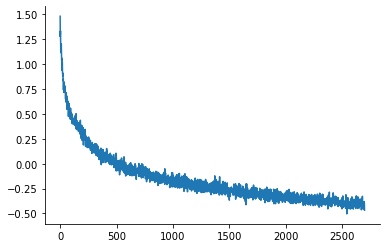

In [40]:
plt.plot(losses)
sns.despine()

In [41]:
mlp_training_time = cap.stdout.split('\n')[1]
mlp_training_time

'Wall time: 12.4 s'

#### Training Results

In [42]:
y_hat = model.apply(params, x_train, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [43]:
train_mean = scaler_y.inverse_transform(y_hat[0])
train_sigma = scaler_y.scale_*y_hat[1]
y_true = scaler_y.inverse_transform(y_train)

In [44]:
print(f"RMSE : {errors.rmse(y_true, train_mean):.4f} MAE  : {errors.mae(y_true, train_mean):.4f} NLL : {errors.NLL(train_mean,train_sigma,y_true):.4f}")

RMSE : 24.7458 MAE  : 12.4237 NLL : 3.7267


In [45]:
training_predictions_df['mean']=train_mean
training_predictions_df['sigma']=train_sigma
training_predictions_df.head()

,Ground Truth,mean,sigma
0,6.937500,9.744553,2.106262
1,6.133332,10.806725,2.944088
2,6.937500,10.339001,2.112746
3,6.400002,10.628765,2.572621
4,6.062500,34.545460,50.476910


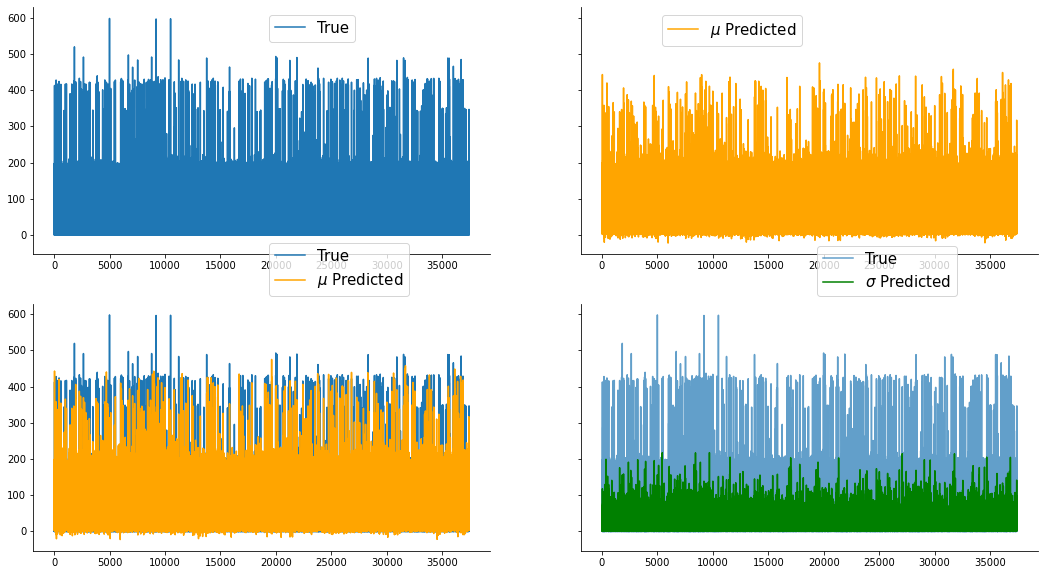

In [46]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10),sharey='row')
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

#### Testing Results

In [47]:
%%capture cap
%%time
test_yhat = model.apply(params, x_test, True, rngs={"dropout":jax.random.PRNGKey(0)})

In [48]:
mlp_testing_time = cap.stdout.split('\n')[1]

In [49]:
test_mean = scaler_y.inverse_transform(test_yhat[0])
test_sigma = scaler_y.scale_*test_yhat[1]

In [50]:
testing_predictions_df["mean"] = test_mean
testing_predictions_df['sigma'] = test_sigma

In [51]:
print(f"RMSE : {errors.rmse(y_test, test_mean):.4f} MAE  : {errors.mae(y_test,test_mean):.4f} NLL : {errors.NLL(test_mean,test_sigma,y_test):.4f}")

RMSE : 45.6116 MAE  : 27.0382 NLL : 5.0698


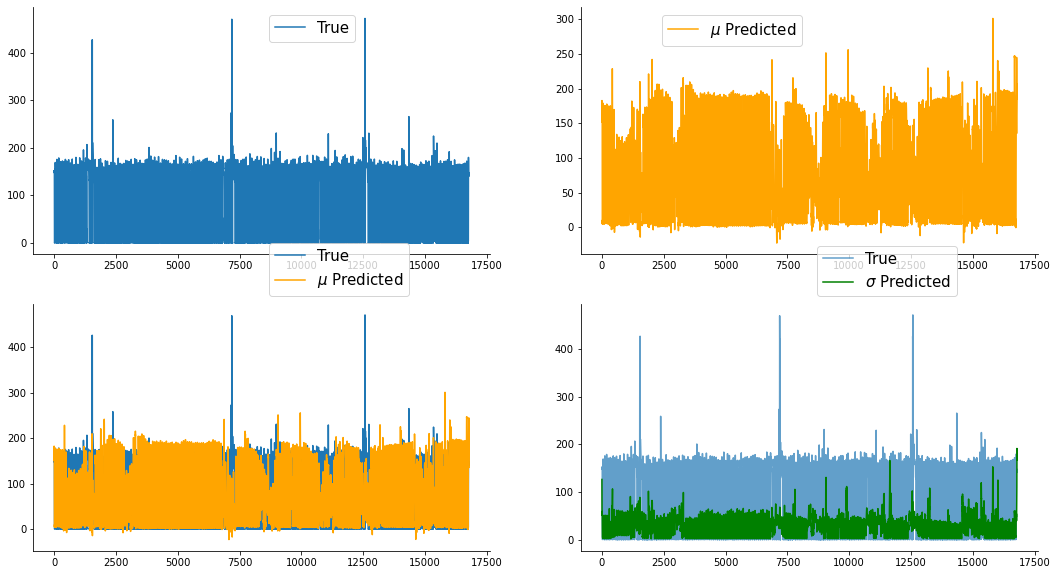

In [52]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

## MC Dropout

In [ ]:
n_stacks = 10
fn = lambda x, i : model.apply(params, x, False, rngs={"dropout": jax.random.PRNGKey(i)})

#### Training Results

In [119]:
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_train, jnp.arange(n_stacks))

In [120]:
mc_train_mean,mc_train_sigma =  gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [121]:
mc_train_mean = scaler_y.inverse_transform(mc_train_mean)
mc_train_sigma = (scaler_y.scale_*mc_train_sigma)

In [122]:
print(f"RMSE : {errors.rmse(y_true, mc_train_mean):.4f}", f"MAE  : {errors.mae(y_true, mc_train_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_train_mean, mc_train_sigma, y_true):.4f}")

RMSE : 59.2931 MAE  : 9.9460 NLL  : 1.2499


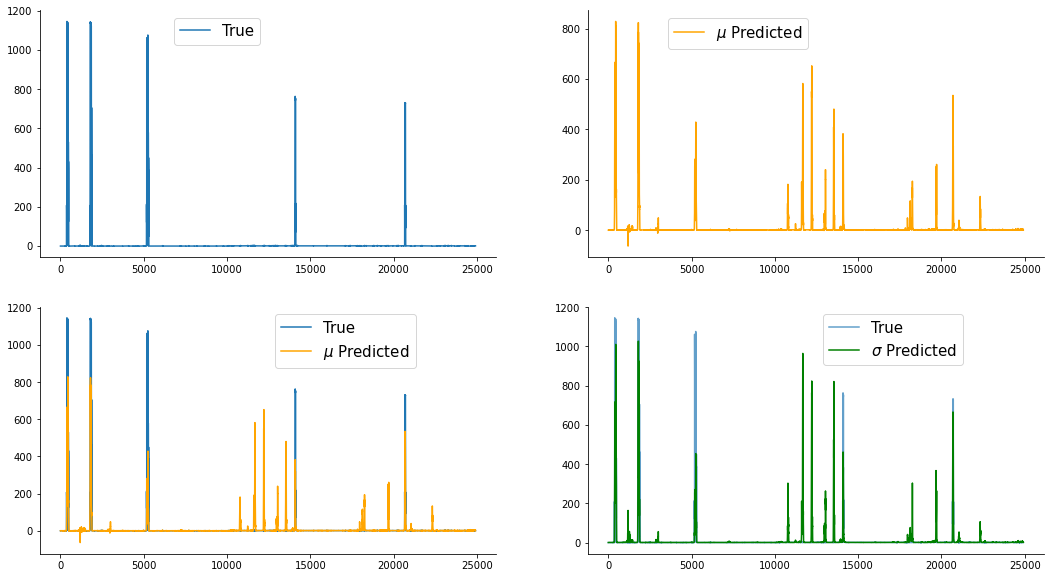

In [123]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(mc_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [124]:
training_predictions_df['MC_mean']=mc_train_mean
training_predictions_df['MC_sigma']=mc_train_sigma

In [125]:
training_predictions_df.head()

,Ground Truth,mean,sigma,MC_mean,MC_sigma
0,8.209751e-08,0.944768,0.524089,0.145570,0.364048
1,8.209751e-08,0.954549,0.529825,0.424585,0.485256
2,8.209751e-08,0.960463,0.534339,0.725609,0.530492
3,8.209751e-08,0.954435,0.537413,0.722068,0.639779
4,8.209751e-08,0.979891,0.539763,0.372746,0.455781


#### Testing Results

In [126]:
%%capture cap
%%time
y_stacks = jax.vmap(jax.jit(fn), in_axes=(None, 0))(x_test, jnp.arange(n_stacks))

In [127]:
mc_testing_time = cap.stdout.split('\n')[1]
mc_testing_time

'Wall time: 734 ms'

In [128]:
mc_test_mean,mc_test_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])


In [129]:
mc_test_mean = scaler_y.inverse_transform(mc_test_mean)
mc_test_sigma = (scaler_y.scale_*mc_test_sigma)

In [130]:
print(f"RMSE : {errors.rmse(y_test, mc_test_mean):.4f}", f"MAE  : {errors.mae(y_test, mc_test_mean):.4f}", 
      f"NLL  : {errors.NLL(mc_test_mean, mc_test_sigma, y_test):.4f}")

RMSE : 88.1152 MAE  : 9.5098 NLL  : 4.9647


In [131]:
testing_predictions_df['MC_Mean'] =  mc_test_mean
testing_predictions_df['MC_Sigma'] = mc_test_sigma

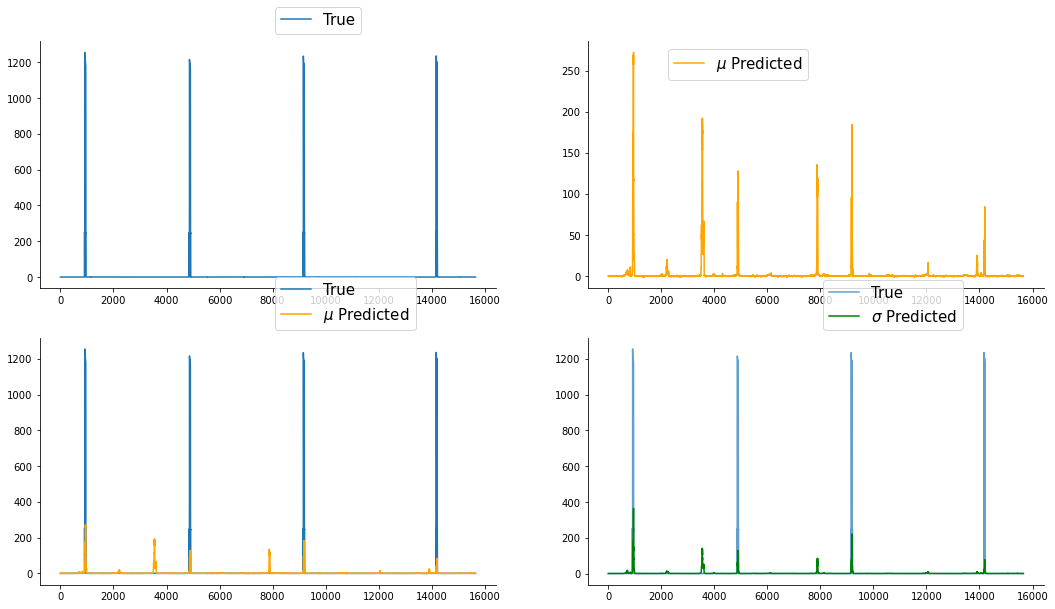

In [132]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(mc_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(mc_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

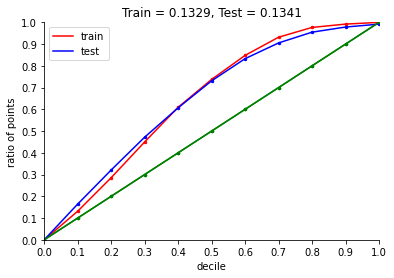

In [133]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(mc_train_mean.squeeze(), mc_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)

df, df2 = plot.calibration_regression(mc_test_mean.squeeze(), mc_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Test = {errors.ace(df2):.4f}')
ax.legend()

## Deep Ensemble

In [71]:
def de_train(x, y, i, model):
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, x, y, False, batch_size=1024, 
                      learning_rate=0.0001, epochs=50)
    return param, losses
    
de_train = jax.tree_util.Partial(de_train, model=model)

def predict(x, param, model):
    yhat = model.apply(param,x,True)
    return yhat
test_ = jax.tree_util.Partial(predict, model=model)

In [72]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(de_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

2022-07-20 16:07:56.355069: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[8,30,300]{0,2,1}, u8[0]{0}) custom-call(f32[10240,106,30]{1,0,2}, f32[1024,99,300]{1,0,2}), window={size=99}, dim_labels=f0b_i0o->0bf, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"


In [73]:
de_training_time = cap.stdout.split('\n')[1]
de_training_time

'Wall time: 1min 25s'

#### Training Results

In [74]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
de_train_mean,de_train_sigma = gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

2022-07-20 16:09:20.900336: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[24918,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[24918,99,400]{1,2,0}, f32[5,40,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-20 16:09:22.877810: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[24918,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[24918,99,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\

In [75]:
de_train_mean = scaler_y.inverse_transform(de_train_mean)
de_train_sigma = scaler_y.scale_*de_train_sigma

In [76]:
print(f"RMSE : {errors.rmse(y_true, de_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, de_train_mean):.4f}", 
      f"NLL  : {errors.NLL(de_train_mean, de_train_sigma, y_true):.4f}")

RMSE : 27.5762 MAE  : 5.5017 NLL  : 1.8585


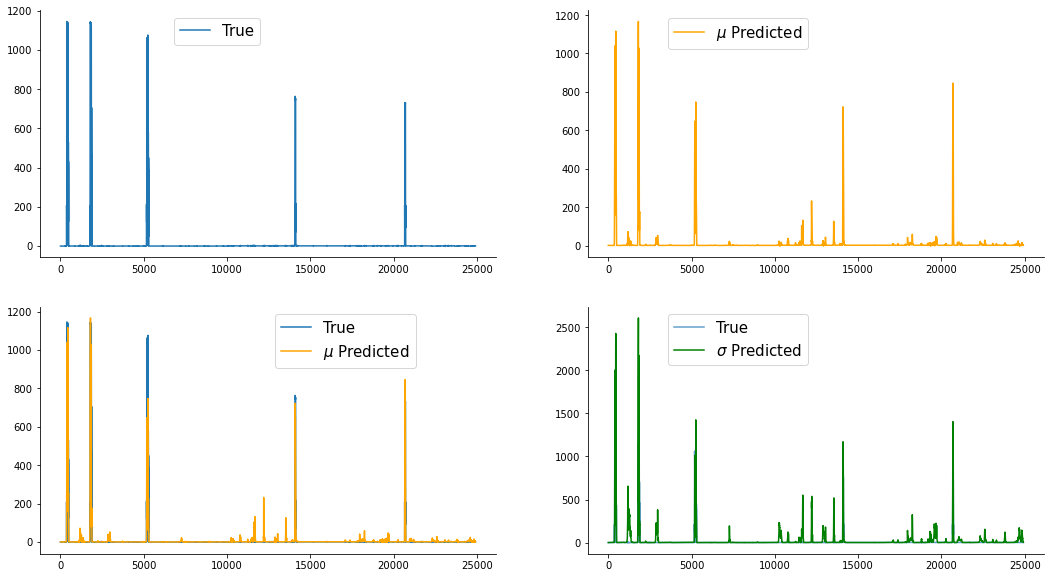

In [77]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(de_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [78]:
training_predictions_df['DE_mean']=de_train_mean
training_predictions_df['DE_sigma']=de_train_sigma

#### Testing Results

In [79]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_test, params_list)

2022-07-20 16:09:28.779250: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[15656,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[15656,99,400]{1,2,0}, f32[5,40,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\"activation_mode\":\"0\",\"side_input_scale\":0}"
2022-07-20 16:09:30.088537: W external/org_tensorflow/tensorflow/compiler/xla/service/gpu/gpu_conv_algorithm_picker.cc:727] None of the algorithms provided by cuDNN heuristics worked; trying fallback algorithms.  Conv: (f32[15656,99,500]{1,2,0}, u8[0]{0}) custom-call(f32[15656,99,500]{1,2,0}, f32[5,50,500]{0,1,2}), window={size=5 pad=2_2}, dim_labels=b0f_0io->b0f, feature_group_count=10, custom_call_target="__cudnn$convForward", backend_config="{\"conv_result_scale\":1,\

In [80]:
de_testing_time = cap.stdout.split('\n')[1]
de_testing_time

'Wall time: 4.33 s'

In [81]:
de_test_mean, de_test_sigma= gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [82]:
de_test_mean = scaler_y.inverse_transform(de_test_mean)
de_test_sigma = scaler_y.scale_*de_test_sigma

In [83]:
testing_predictions_df['de_Mean'] =  de_test_mean
testing_predictions_df['de_Sigma'] = de_test_sigma

In [84]:
print(f"RMSE : {errors.rmse(y_test, de_test_mean):.4f}", f"MAE  : {errors.mae(y_test, de_test_mean):.4f}", 
      f"NLL  : {errors.NLL(de_test_mean, de_test_sigma, y_test):.4f}")

RMSE : 90.9260 MAE  : 9.9181 NLL  : 5.4337


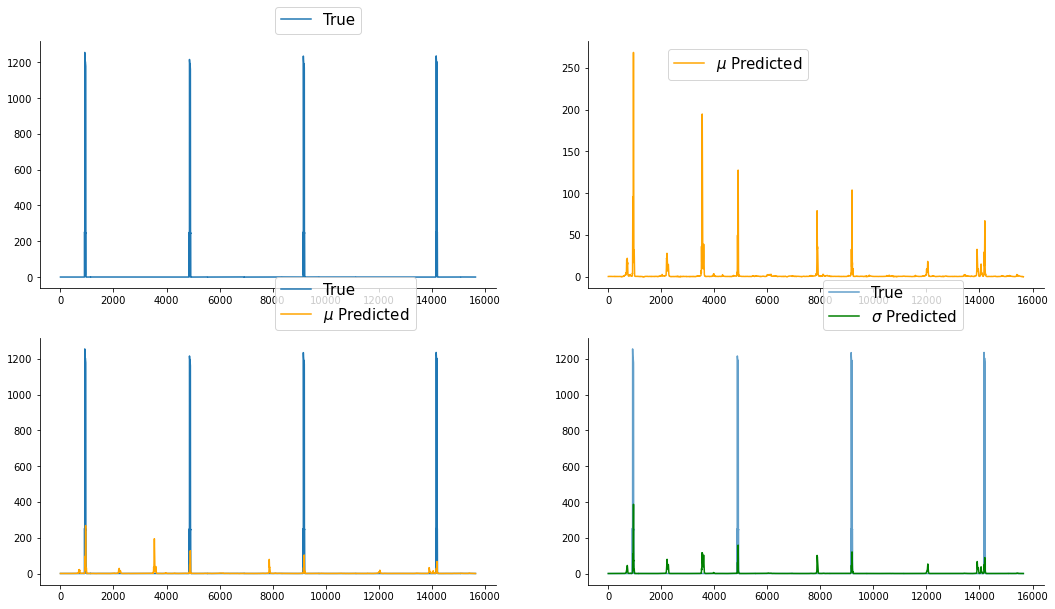

In [85]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(de_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(de_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

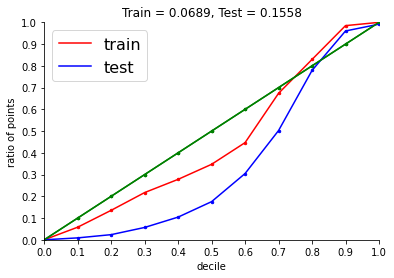

In [86]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(de_train_mean.squeeze(), de_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)

df, df2 = plot.calibration_regression(de_test_mean.squeeze(), de_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Test = {errors.ace(df2):.4f}')
ax.legend(fontsize=16)
# plt.savefig("de_calib_lstm.pdf")

## Bootstrap

In [54]:
def bs_train(x, y, i, model):
    idx = jax.random.choice(jax.random.PRNGKey(i), jnp.arange(len(x)), (len(x),))
    new_x, new_y = x[idx], y[idx]
    param =  model.init(jax.random.PRNGKey(i),x_train, True)
    param, losses = fit(model, param, new_x, new_y, True, batch_size=1024, 
                      learning_rate=0.0001, epochs= 50)
    return param, losses

bs_train = jax.tree_util.Partial(bs_train, model=model)

In [55]:
%%capture cap
%%time
params_list, losses_list = jax.jit(jax.vmap(bs_train, in_axes=(None, None, 0)))(x_train, y_train, jnp.arange(10))

In [56]:
bs_training_time = cap.stdout.split('\n')[1]
bs_training_time

'Wall time: 1min 26s'

#### Training Results

In [57]:
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None,0)))(x_train, params_list)
bs_train_mean,bs_train_sigma=gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [58]:
bs_train_mean = scaler_y.inverse_transform(bs_train_mean)
bs_train_sigma = scaler_y.scale_*bs_train_sigma

In [59]:
print(f"RMSE : {errors.rmse(y_true, bs_train_mean):.4f}", 
      f"MAE  : {errors.mae(y_true, bs_train_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_train_mean, bs_train_sigma, y_true):.4f}")

RMSE : 86.3614 MAE  : 14.3372 NLL  : 3.6539


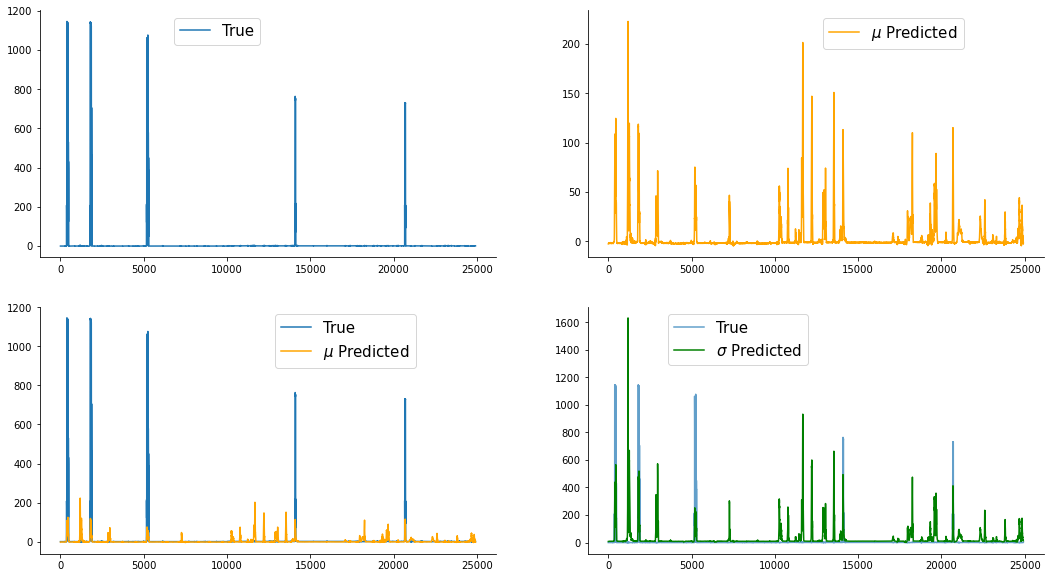

In [60]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_true[idx1:idx2], label="True")
ax[1].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_true[idx1:idx2], label="True")
ax[2].plot(bs_train_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_true[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_train_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

In [61]:
training_predictions_df['BS_mean']=bs_train_mean
training_predictions_df['BS_sigma']=bs_train_sigma

#### Testing Results

In [62]:
%%capture cap
%%time
y_stacks = jax.jit(jax.vmap(test_, in_axes=(None, 0)))(x_test, params_list)

In [63]:
bs_testing_time = cap.stdout.split('\n')[1]
bs_testing_time

'Wall time: 281 ms'

In [64]:
bs_test_mean,bs_test_sigma=gmm.gmm_mean_var(y_stacks[0],y_stacks[1])

In [65]:
bs_test_mean = scaler_y.inverse_transform(bs_test_mean)
bs_test_sigma = scaler_y.scale_*bs_test_sigma

In [66]:
print(f"RMSE : {errors.rmse(y_test, bs_test_mean):.4f}", f"MAE  : {errors.mae(y_test, bs_test_mean):.4f}", 
      f"NLL  : {errors.NLL(bs_test_mean, bs_test_sigma, y_test):.4f}")

RMSE : 94.3669 MAE  : 11.7599 NLL  : 3.9361


In [67]:
testing_predictions_df['bs_Mean'] =  bs_test_mean
testing_predictions_df['bs_Sigma'] = bs_test_sigma

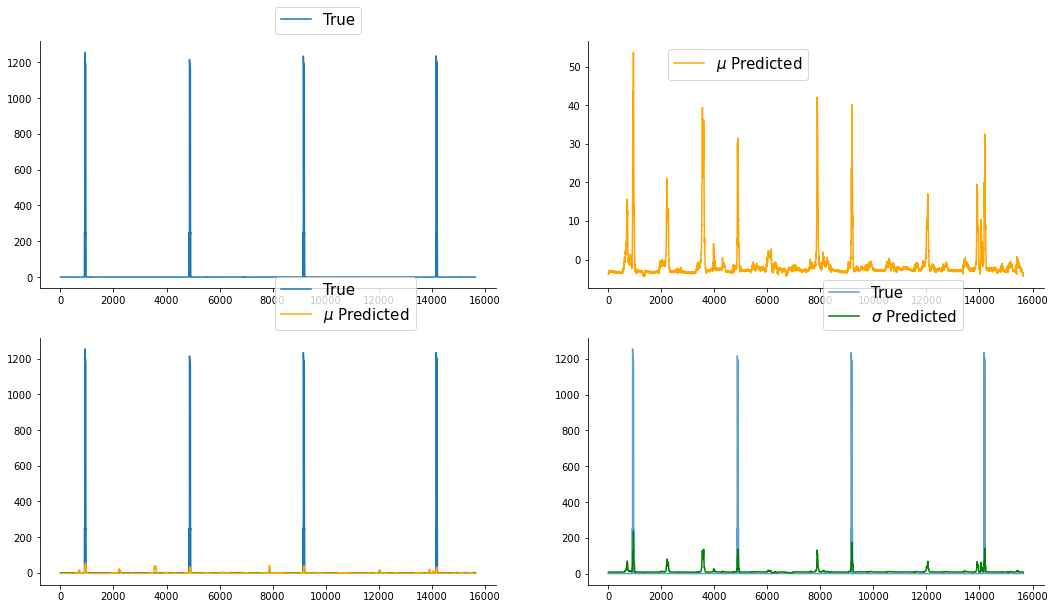

In [68]:
idx1 = 0
idx2 = -1
fig, ax = plt.subplots(2, 2, figsize=(18,10))
ax = ax.ravel()
ax[0].plot(y_test[idx1:idx2], label="True")
ax[1].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[2].plot(y_test[idx1:idx2], label="True")
ax[2].plot(bs_test_mean[idx1:idx2], label=f"$\mu$ Predicted", color="orange")
ax[3].plot(y_test[idx1:idx2], label="True", alpha=0.7)
ax[3].plot(bs_test_sigma[idx1:idx2], label=f"$\sigma$ Predicted", color="green")
ax[0].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[1].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[2].legend(fontsize=15, bbox_to_anchor=(0.5,1))
ax[3].legend(fontsize=15, bbox_to_anchor=(0.5,1))
sns.despine()

### Calibration

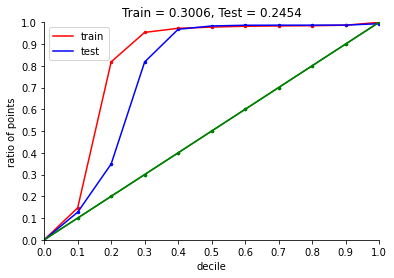

In [69]:
fig, ax = plt.subplots(1)
df, df1 = plot.calibration_regression(bs_train_mean.squeeze(), bs_train_sigma.squeeze(), 
                                     y_true.squeeze(), "train", "r", ax)

df, df2 = plot.calibration_regression(bs_test_mean.squeeze(), bs_test_sigma.squeeze(), 
                                      y_test.squeeze(), "test", "b", ax)

_ = ax.set_title(f'Train = {errors.ace(df1):.4f}, Test = {errors.ace(df2):.4f}')
ax.legend()
# plt.savefig("bs_calib_lstm.pdf")

## Save Results

In [70]:
testing_predictions_df.head()

,Timestamp,Ground Truth,mean,sigma,MC_Mean,MC_Sigma,de_Mean,de_Sigma,bs_Mean,bs_Sigma
0,2011-04-21 00:00:00-04:00,0.1250,0.456446,0.466712,0.193775,0.438323,0.456696,0.390398,-3.809105,7.187853
1,2011-04-21 00:01:00-04:00,0.1250,0.451538,0.465934,0.023177,0.393437,0.458813,0.389424,-3.799024,7.222480
2,2011-04-21 00:02:00-04:00,0.1250,0.433699,0.460120,-0.169868,0.402173,0.450683,0.387607,-3.816152,7.235334
3,2011-04-21 00:03:00-04:00,0.0625,0.430574,0.463470,-0.245154,0.312927,0.438219,0.387255,-3.768829,7.261149
4,2011-04-21 00:04:00-04:00,0.1250,0.440487,0.461049,-0.238379,0.347050,0.434584,0.388076,-3.740302,7.273909


In [71]:
# training_predictions_df.to_csv("notebooks/dish washer/s2p/gmlp/training_predictions.csv",index=False)
# testing_predictions_df.to_csv("notebooks/dish washer/s2p/gmlp/testing_predictions.csv",index=False)

In [72]:
# with open('notebooks/dish washer/s2p/gmlp/time.txt', 'w') as file:
#     file.writelines([f"MLP training :{mlp_training_time} ",f" MLP Testing : {mlp_testing_time}\n"
#                f"MC Testing : {mc_testing_time}\n", 
#                f"DE Training Time : {de_training_time} ",f" DE Testing Time: {de_testing_time}\n", 
#                f"BS Training Time : {bs_training_time} ",f" BS Testing Time: {bs_testing_time}"])

: 